# IPT

In [337]:
using PyPlot
using LaTeXStrings
using QuadGK
using FastGaussQuadrature
using TensorOperations
using Einsum
using LinearAlgebra
import PyCall: pyimport
sparse_ir = pyimport("sparse_ir")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")

rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.size"] = 16
rcParams["text.latex.preamble"] = raw"\usepackage{amsmath}"

"\\usepackage{amsmath}"

## Step 1: Generate IR basis and associated sampling points

In [338]:
lambda_ = 100
beta    = 10
basis   = sparse_ir.FiniteTempBasis("F", beta, lambda_/beta, eps=1e-10)
L = basis.size
# Sparse sampling in tau
smpl_tau = sparse_ir.TauSampling(basis)
print("cond (tau): ", smpl_tau.cond)

# Sparse sampling in Matsubara frequencies
smpl_matsu = sparse_ir.MatsubaraSampling(basis)
print("cond (matsu): ", smpl_matsu.cond)

cond (tau): 5.89770217368647cond (matsu): 11.266380245503292

## Step 2
Define a non-interacting DOS:
$$
\rho(\omega) = \frac{\sqrt{4-\omega^2}}{2\pi}.
$$

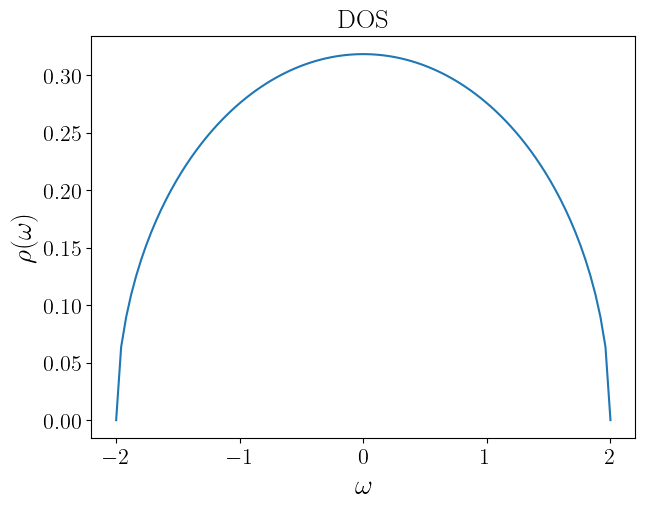

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [339]:
function rho_omega(omega)
    return sqrt(4-omega^2)/(2*pi)
end

@assert abs(quadgk(rho_omega,-2,2)[1]-1) < 1e-9

num_omega = 100
omegas = collect(range(-2,2,num_omega))
plt.figure()
plt.plot(omegas,rho_omega.(omegas))
plt.tight_layout()
plt.title("DOS")
fontsize = 20
plt.xlabel(L"$\omega$",fontsize=fontsize)
plt.ylabel(L"$\rho(\omega)$",fontsize=fontsize)
plt.show()

In [340]:
module IPT
import PyCall: pyimport
sparse_ir = pyimport("sparse_ir")
using FastGaussQuadrature

function rho_omega(omega)
    return sqrt(4-omega^2)/(2*pi)
end

function scale_quad(x, w, x_min, x_max)
    @assert x_min < x_max
    dx = x_max - x_min
    x_ = 0.5 .* dx .* (x .+ 1) .+ x_min
    w_ = 0.5 .* dx .* w
    return x_, w_
end

struct IPTSolver
    U::Float64
    basis
    beta::Float64
    rho_omega
    omega_range::Tuple{Float64,Float64}
    quad_rule
    smpl_matsu
    smpl_tau
end

function IPTSolver(U,basis,rho_omega,omega_range,deg_leg_gauss=1000)
    @assert omega_range[1] < omega_range[2]
    x_,w_ = gausslegendre(deg_leg_gauss)
    quad_rule = scale_quad(x_,w_,omega_range[1],omega_range[2])
    smpl_matsu = sparse_ir.MatsubaraSampling(basis)
    smpl_tau = sparse_ir.TauSampling(basis)

    return IPTSolver(U,basis,basis.beta,rho_omega,omega_range,quad_rule,smpl_matsu,smpl_tau)
end

U = 2.0
omega_range = (-2.0,2.0)
lambda_ = 100
beta    = 10
basis   = sparse_ir.FiniteTempBasis("F", beta, lambda_/beta, eps=1e-10)

solver = IPTSolver(U,basis,rho_omega,omega_range)
    
end

Main.IPT

In [341]:
U = 2.0
omega_range = (-2.0,2.0)
lambda_ = 100
beta    = 10
basis   = sparse_ir.FiniteTempBasis("F", beta, lambda_/beta, eps=1e-10)

solver = IPT.IPTSolver(U,basis,rho_omega,omega_range)
solver.beta
solver.U

2.0

In [342]:
qr = solver.quad_rule
x = qr[1]
w = qr[2]

1000-element Vector{Float64}:
 1.482667683286414e-5
 3.451353954747845e-5
 5.422921313041171e-5
 7.394688401287099e-5
 9.36643341394255e-5
 0.00011338101302303457
 0.00013309663186061572
 0.00015281096416832146
 0.00017252380265613814
 0.00019223494709094108
 0.00021194420019803414
 0.00023165136607808355
 0.00025135624952912284
 ⋮
 0.00023165136607808355
 0.00021194420019803414
 0.00019223494709094108
 0.00017252380265613814
 0.00015281096416832146
 0.00013309663186061572
 0.00011338101302303457
 9.36643341394255e-5
 7.394688401287099e-5
 5.422921313041171e-5
 3.451353954747845e-5
 1.482667683286414e-5

In [343]:
solver.smpl_matsu.sampling_points

32-element Vector{Int64}:
 -229
 -217
  -93
  -55
  -39
  -29
  -23
  -17
  -15
  -13
  -11
   -9
   -7
    ⋮
    9
   11
   13
   15
   17
   23
   29
   39
   55
   93
  217
  229

In [344]:
z = [1 2;3 4]

2×2 Matrix{Int64}:
 1  2
 3  4

## Self-consistent equation

$$
\begin{align*}
  G_\mathrm{loc}(\mathrm{i}\nu) &= \int \mathrm{d}\omega \frac{\rho(\omega)}{\mathrm{i}\nu - \omega - \Sigma(\mathrm{i}\nu)}\\
  \mathcal{G}(\mathrm{i}\nu) &= (G^{-1}_{\mathrm{loc}}(\mathrm{i}\nu) + \Sigma(\mathrm{i}\nu))^{-1}\\
  \Sigma(\tau) &= U^2 \mathcal{G}(\tau)^2 \mathcal{G}(\beta-\tau)
\end{align*}
$$

In [345]:
const newaxis = [CartesianIndex()]

1-element Vector{CartesianIndex{0}}:
 CartesianIndex()

In [346]:
function compute_gloc_iv(solver,sigma_iv)
    quad_points = solver.quad_rule[1]
    quad_weight = solver.quad_rule[2] 
    # sampling Matsubara frequencies
    iv = im .* solver.smpl_matsu.sampling_points .* (pi/solver.beta)
    gloc_iv = zeros(ComplexF64,length(iv))
    temp = (iv .- sigma_iv)[newaxis,:] .- quad_points[:,newaxis]

    for j in 1:length(iv)
        for i in 1:length(quad_points)
            gloc_iv[j] += quad_weight[i] * solver.rho_omega.(quad_points)[i] / temp[i,j]
        end
    end

    #@tensor gloc_iv[j] = quad_weight[i] * solver.rho_omega.(quad_points)[i] * (1 ./ temp)[i,j] 

    return gloc_iv
end

len_iv = length(solver.smpl_matsu.sampling_points)
sigma_iv = zeros(ComplexF64,len_iv)
gloc_iv = compute_gloc_iv(solver,sigma_iv)

32-element Vector{ComplexF64}:
  2.7489231239054475e-21 + 0.013897310458286651im
 -1.4210374042150712e-20 + 0.014665503466246812im
   1.663382340544285e-20 + 0.03418686712409238im
  -6.328324596821624e-20 + 0.05768196415180551im
  -2.943653524692192e-19 + 0.08108134827108833im
    5.90776322593282e-19 + 0.1084705842600468im
  -3.278226368978812e-19 + 0.13584178982805456im
  -7.574043089689999e-19 + 0.18110011577070237im
  -5.356676476695904e-18 + 0.20342510578177503im
 -1.7864520427634232e-18 + 0.2317079136786483im
  -6.707395828955688e-18 + 0.2685096074396494im
  5.8631777773259055e-18 + 0.31792844610473436im
    3.63699569374868e-17 + 0.3867219997228807im
                         ⋮
  5.8631777773259055e-18 - 0.31792844610473436im
  -6.707395828955688e-18 - 0.2685096074396494im
 -1.7864520427634232e-18 - 0.2317079136786483im
  -5.356676476695904e-18 - 0.20342510578177503im
  -7.574043089689999e-19 - 0.18110011577070237im
  -3.278226368978812e-19 - 0.13584178982805456im
    5.907763225

In [347]:
function compute_g0_iv(solver,gloc_iv,sigma_iv)
    return 1 ./ ((1 ./ gloc_iv) .+ sigma_iv)
end

g0_iv = compute_g0_iv(solver,gloc_iv,sigma_iv)

32-element Vector{ComplexF64}:
  2.7489231239054475e-21 + 0.013897310458286651im
 -1.4210374042150712e-20 + 0.01466550346624681im
   1.663382340544285e-20 + 0.03418686712409238im
  -6.328324596821623e-20 + 0.0576819641518055im
  -2.943653524692192e-19 + 0.08108134827108833im
    5.90776322593282e-19 + 0.1084705842600468im
  -3.278226368978812e-19 + 0.13584178982805456im
  -7.574043089689999e-19 + 0.18110011577070237im
  -5.356676476695905e-18 + 0.20342510578177503im
 -1.7864520427634232e-18 + 0.23170791367864832im
  -6.707395828955688e-18 + 0.2685096074396494im
  5.8631777773259055e-18 + 0.31792844610473436im
    3.63699569374868e-17 + 0.3867219997228807im
                         ⋮
  5.8631777773259055e-18 - 0.31792844610473436im
  -6.707395828955688e-18 - 0.2685096074396494im
 -1.7864520427634232e-18 - 0.23170791367864832im
  -5.356676476695905e-18 - 0.20342510578177503im
  -7.574043089689999e-19 - 0.18110011577070237im
  -3.278226368978812e-19 - 0.13584178982805456im
    5.907763225

In [348]:
function compute_sigma_iv(solver,g0_iv)
    g0_IR = solver.smpl_matsu.fit(g0_iv, axis=0) # axis for Fourier transform
    g0_tau = solver.smpl_tau.evaluate(g0_IR)
    sigma_tau = solver.U^2 .* g0_tau.^2 .* reverse(g0_tau)
    sigma_IR = solver.smpl_tau.fit(sigma_tau)
    return solver.smpl_matsu.evaluate(sigma_IR,axis=0)
end

sigma_iv = compute_sigma_iv(solver,g0_iv)

32-element Vector{ComplexF64}:
 -1.0565507249646445e-15 + 0.01388065006239275im
  -1.073463162667871e-15 + 0.014645928613525332im
   7.538310907447799e-17 + 0.03394100193239812im
  -6.193837842334971e-17 + 0.05652296711424053im
   6.544120079189193e-17 + 0.07794863685936357im
 -1.7219443727385461e-16 + 0.1012718617386264im
  1.3072874437496554e-17 + 0.12238127033531916im
  -3.843857216892678e-16 + 0.15207291937616754im
   2.466092039865501e-17 + 0.1643117230589504im
 -1.3889083555978156e-16 + 0.1776187155939855im
  -7.441257752543015e-17 + 0.1914777510836235im
  -7.910504533196201e-17 + 0.20453792970507448im
  3.3333528891807556e-17 + 0.21365172178497793im
                         ⋮
  -6.657706539304719e-17 - 0.20453792970507442im
 -1.1604221318133044e-16 - 0.19147775108362344im
   9.495877317134956e-18 - 0.17761871559398545im
  -3.446886158888311e-16 - 0.16431172305895034im
  -1.659103014440653e-16 - 0.1520729193761675im
 -2.6140002566686136e-16 - 0.12238127033531913im
   6.4561360983

In [349]:
function mk_new_sigma_iv(solver,sigma_iv)
    gloc_iv = compute_gloc_iv(solver,sigma_iv)
    g0_iv = compute_g0_iv(solver,gloc_iv,sigma_iv)
    return compute_sigma_iv(solver,g0_iv)
end


mk_new_sigma_iv (generic function with 1 method)

In [350]:
function normalize_factor(solver,sigma_history,nitr,mixing) # What is normalize_factor?
    # initialize sigma_iv
    if length(sigma_history) == 0
        sigma_iv = zeros(ComplexF64,length(solver.smpl_matsu.sampling_points))
    else 
        sigma_iv = sigma_history[end]
    end
   
    # mixing sigma_iv with new_sigma_iv
    for i in 1:nitr
        new_sigma_iv = mk_new_sigma_iv(solver,sigma_iv)
        rdiff = maximum(abs.(new_sigma_iv .- sigma_iv)) / maximum(abs.(sigma_iv))
        #println(i,rdiff)
        if rdiff < 1e-5
            break
        end
        sigma_iv = mixing .* new_sigma_iv .+ (1-mixing) .* sigma_iv
    end

    center = Int(length(sigma_iv)/2)
    println("DEBUG A:$(imag(sigma_iv[center]))")
    println("DEBUG B:$(imag(sigma_iv[center-1]))")
    println("DEBUG C:$((solver.smpl_matsu.sampling_points[center]))")
    println("DEBUG D:$((solver.smpl_matsu.sampling_points[center-1]))")
    z = 1/(1 - (imag(sigma_iv[center]) - imag(sigma_iv[center-1])/(solver.smpl_matsu.sampling_points[center] - solver.smpl_matsu.sampling_points[center-1])))

    return z, sigma_iv
end


normalize_factor (generic function with 1 method)

In [351]:

function run(D,Us,rho_omega,omega_range,nitr,mixing)
    # make sparse ir basis
    beta = 10  * D
    wmax = 10.0 * D
    eps = 1e-9
    basis = sparse_ir.FiniteTempBasis("F", beta, wmax, eps=eps)

    Z = []
    sigma_history = []
    for iu in Us
        solver = IPT.IPTSolver(iu,basis,rho_omega,omega_range)
        println(solver.U)
        z, sigma_ = normalize_factor(solver,sigma_history,nitr,mixing) 
        push!(sigma_history,sigma_)
        if abs(z) > 1e-10
            push!(Z,z)
        else 
            break
        end
    end

    return Z, sigma_history
end

D = 2
num_U = 10
Us = 2 .* collect(range(5/D,6.5/D,num_U))
omega_range = (-2.0,2.0)
nitr = 1000
mixing = 0.1
Z,sigma_history = run(D,Us,rho_omega,omega_range,nitr,mixing)

5.0
DEBUG A:0.6930120950714361
DEBUG B:1.5730508606611369
DEBUG C:-1
DEBUG D:-3
5.166666666666667
DEBUG A:0.8171361834380987
DEBUG B:1.8289170240421293
DEBUG C:-1
DEBUG D:-3
5.333333333333333
DEBUG A:0.9818014384327622
DEBUG B:2.151901230804968
DEBUG C:-1
DEBUG D:-3
5.5
DEBUG A:1.219286552291787
DEBUG B:2.583053291207834
DEBUG C:-1
DEBUG D:-3
5.666666666666667
DEBUG A:1.6487612704874817
DEBUG B:3.255711553877465
DEBUG C:-1
DEBUG D:-3
5.833333333333333
DEBUG A:31.0552875312966
DEBUG B:10.822593314022782
DEBUG C:-1
DEBUG D:-3
6.0
DEBUG A:34.62145389942519
DEBUG B:11.939182590273527
DEBUG C:-1
DEBUG D:-3
6.166666666666667
DEBUG A:38.19465840356919
DEBUG B:13.075901143354034
DEBUG C:-1
DEBUG D:-3
6.333333333333333
DEBUG A:41.79769899158613
DEBUG B:14.234527931589533
DEBUG C:-1
DEBUG D:-3
6.5
DEBUG A:45.44506262945353
DEBUG B:15.416382049301943
DEBUG C:-1
DEBUG D:-3


(Any[0.9144835895055892, 0.9113092606903902, 0.9139521566606935, 0.9326269426383959, 1.0213518648210187, -0.0405778433006746, -0.03616392914685297, -0.03261928859039782, -0.029690827901546785, -0.0272206085144515], Any[ComplexF64[8.399906463102314e-15 + 0.045252805518977125im, 8.54466008242703e-15 + 0.04752214114878074im, 8.661791855617321e-15 + 0.05003101379008681im, -7.160343330047745e-16 + 0.11714364117210613im, 2.0406499850379814e-15 + 0.19687580941575658im, 2.518934751733505e-16 + 0.2870887587684795im, 8.548849901697101e-16 + 0.3858460365396033im, -8.398013337830424e-16 + 0.5116295396535345im, 1.329117782984803e-16 + 0.6377421416177158im, 9.469681621368615e-16 + 0.8089042148763546im  …  2.290738753240773e-15 - 0.8089042148763551im, -5.906673685549427e-16 - 0.6377421416177163im, -2.83607704036028e-16 - 0.5116295396535346im, -7.542054099617202e-16 - 0.3858460365396032im, 5.56657840258678e-16 - 0.2870887587684796im, 1.0975758019201864e-15 - 0.19687580941575672im, -3.345526943795638e-

In [352]:
sigma_history[1]


44-element Vector{ComplexF64}:
  8.399906463102314e-15 + 0.045252805518977125im
   8.54466008242703e-15 + 0.04752214114878074im
  8.661791855617321e-15 + 0.05003101379008681im
 -7.160343330047745e-16 + 0.11714364117210613im
 2.0406499850379814e-15 + 0.19687580941575658im
  2.518934751733505e-16 + 0.2870887587684795im
  8.548849901697101e-16 + 0.3858460365396033im
 -8.398013337830424e-16 + 0.5116295396535345im
  1.329117782984803e-16 + 0.6377421416177158im
  9.469681621368615e-16 + 0.8089042148763546im
 2.5058035158253244e-15 + 0.9946506671300523im
  8.058515346213025e-16 + 1.1484498842536373im
  1.201754146568383e-15 + 1.3501998849322845im
                        ⋮
 2.3213239618541108e-15 - 1.1484498842536373im
 1.0343599249518778e-15 - 0.9946506671300525im
  2.290738753240773e-15 - 0.8089042148763551im
 -5.906673685549427e-16 - 0.6377421416177163im
  -2.83607704036028e-16 - 0.5116295396535346im
 -7.542054099617202e-16 - 0.3858460365396032im
   5.56657840258678e-16 - 0.2870887587684796

In [353]:
sigma_history[2]

44-element Vector{ComplexF64}:
     9.1909192129265e-15 + 0.04832027799395186im
    9.35092878808947e-15 + 0.05074347762237423im
   9.481005592936085e-15 + 0.05342246145369446im
  -7.830413514086602e-16 + 0.1250892745853141im
   2.181442405586039e-15 + 0.2102479718369785im
  3.1023336246304685e-16 + 0.3066367877723531im
   8.303168284830696e-16 + 0.4122222318976822im
  -8.821013525411313e-16 + 0.5468531363168535im
  2.9735003569348317e-17 + 0.6820779056308142im
   8.706154689642133e-16 + 0.8661637500252509im
   2.569438752901928e-15 + 1.0669783906034134im
   7.691123630386766e-16 + 1.2344191390483281im
  1.1053067268778094e-15 + 1.4563575072610733im
                         ⋮
  2.3776913441467988e-15 - 1.234419139048328im
  1.0643176093096914e-15 - 1.0669783906034134im
  2.3015736049486063e-15 - 0.8661637500252517im
   -6.42741385317314e-16 - 0.6820779056308147im
 -3.7427759247786725e-16 - 0.5468531363168535im
  -8.765787318838838e-16 - 0.41222223189768215im
   5.819235957697828e-16 - 

In [354]:
sigma_history[3]

44-element Vector{ComplexF64}:
  1.0060017575450704e-14 + 0.05148838262358944im
  1.0236178108074481e-14 + 0.054070500356734885im
  1.0379816584599142e-14 + 0.056925184267190634im
  -8.778220147234342e-16 + 0.13329645262710607im
   2.263089701393316e-15 + 0.22406349898256772im
   3.217021851621478e-16 + 0.326841209062426im
   8.094946492033203e-16 + 0.4395013983727434im
   -9.27291995678279e-16 + 0.5833229074668379im
 -1.4747070088201624e-16 + 0.7280496373006391im
   7.449345775605368e-16 + 0.9256922090763869im
  2.2913923835354193e-15 + 1.142459074169794im
  3.3264676437154783e-16 + 1.3245036297805985im
  4.3761334178108647e-16 + 1.568388195659499im
                         ⋮
   1.914788038475358e-15 - 1.324503629780598im
   7.292614004657168e-16 - 1.1424590741697944im
  2.1572414915323253e-15 - 0.9256922090763877im
  -7.663066561273397e-16 - 0.7280496373006395im
    -5.4059999611278e-16 - 0.5833229074668379im
  -9.682993601525678e-16 - 0.43950139837274327im
   5.682901794450204e-16 -

In [355]:
x = [1,2]
y = [3,4,5]
#z1 = broadcast(-,x,y[:,newaxis]) # dimension unmatched error
z2 = broadcast(-,x,y[newaxis,:])

y = [1 2;3 4]
z = [3,4]


2-element Vector{Int64}:
 3
 4

In [356]:
using TensorOperations
α=randn()
A=randn(5,5,5,5,5,5)
B=randn(5,5,5)
C=randn(5,5,5)
D=zeros(5,5,5)
println(typeof(A))
@tensor begin
    D[a,b,c] = A[a,e,f,c,f,g]*B[g,b,e] + α*C[c,a,b]
    E[a,b,c] := A[a,e,f,c,f,g]*B[g,b,e] + α*C[c,a,b]
end

Array{Float64, 6}


5×5×5 Array{Float64, 3}:
[:, :, 1] =
  10.105      5.86708   -4.60872   1.04186  -7.26486
 -14.3669     5.93079   -4.68359   7.22336   7.14118
  -0.68108   -8.32887    1.00013  12.0189   -0.751057
  -0.422035  22.5226   -10.2732   -2.04699  20.0661
  -1.66555    3.81622  -10.8098   -2.91974   4.44451

[:, :, 2] =
 -7.4296     0.628208    2.40466   13.28       0.00960121
 -2.04811    0.837815  -15.6665   -13.4841   -19.3697
 -0.2172     2.74124     2.32386  -16.9038   -23.9202
  0.193789  -2.46063    27.9405    -4.86581   -1.69766
 -3.86052   14.1526     -8.36419   -1.24803  -10.8448

[:, :, 3] =
  -8.31095   18.0418      8.84101   -7.61746    -9.06903
  12.1661   -12.1272    -12.1635    -0.220288    8.81171
  12.1265    -0.932135  -14.5563    -4.16819    24.683
   4.10998   23.1548      7.64579  -10.8756    -15.9577
 -13.6681    -0.26145    -4.21927   -3.66653     1.64093

[:, :, 4] =
 -4.21713  -9.63371     0.212547   -2.39323  11.2282
  6.83619  11.4086      7.51471    10.1839   21.3

In [357]:
a = [1,2]
b = [3,4]
c = 0
inner_prod = dot(a,b)
println(inner_prod)
@einsum c = a[i] * b[i]
println(c)

11
0


In [358]:
x = [1,2]
1 ./ x

2-element Vector{Float64}:
 1.0
 0.5

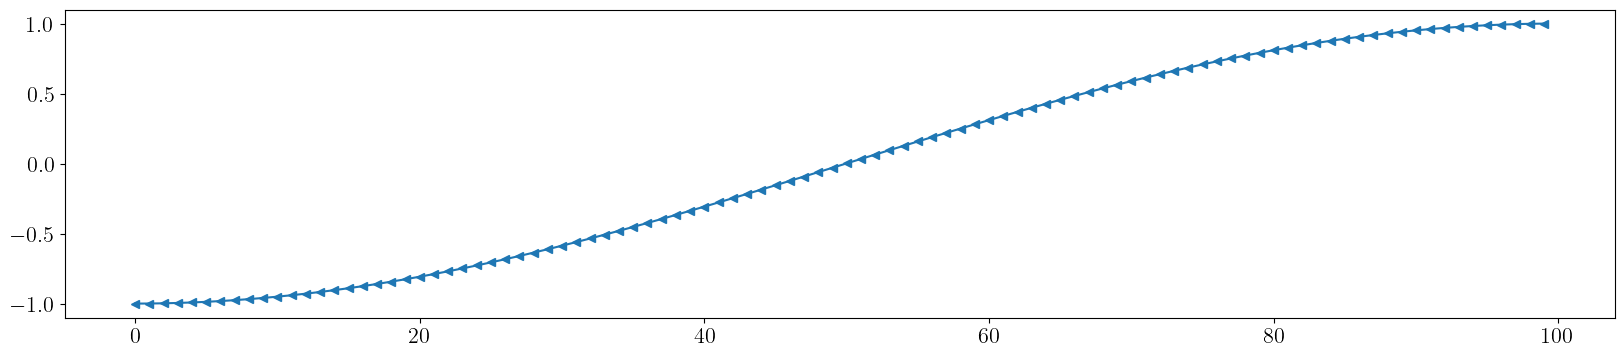

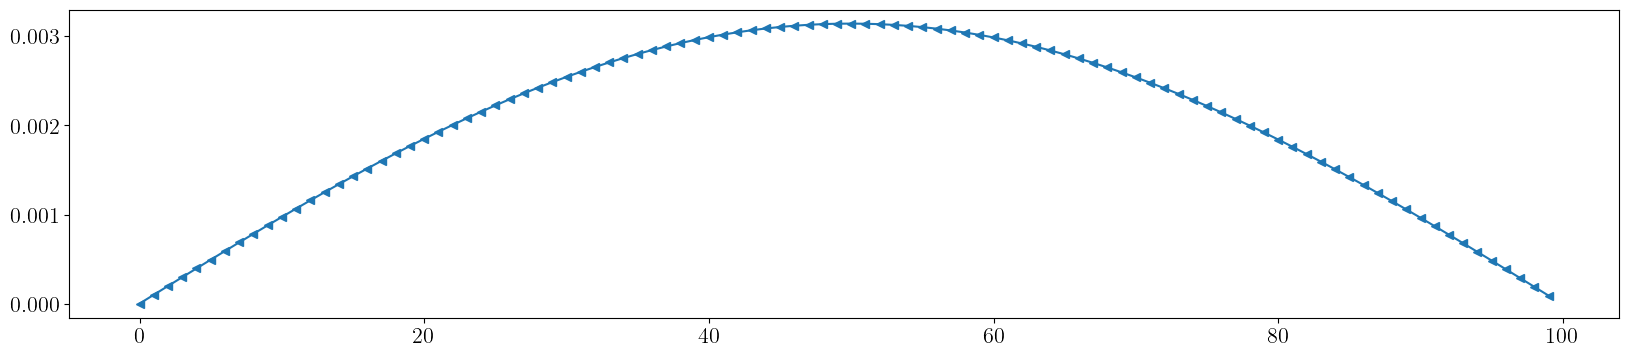

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [359]:
fig = plt.figure(figsize=(20,4))
plt.plot(gausslegendre(1000)[1][1:10:end] ,marker= "<")
plt.show()
fig = plt.figure(figsize=(20,4))
plt.plot(gausslegendre(1000)[2][1:10:end] ,marker= "<")
plt.show()

In [360]:
test = (1,2)
typeof(typeof(test))

DataType

In [361]:
module Test


struct Point
    x::Float64
    y::Float64
end

function compute_distance(p1::Point,p2::Point)
    return sqrt((p1.x-p2.x)^2 + (p1.y-p2.y)^2)
end

p1 = Point(0.0,1.0)
p2 = Point(0.0,0.0)
distance = compute_distance(p1,p2)
println(distance)

end

1.0


Main.Test

In [362]:
from numpy.polynomial.legendre import leggauss

def scale_quad(x, w, xmin, xmax):
    """ Scale weights and notes of quadrature to the interval [xmin, xmax] """
    assert xmin < xmax
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x + 1) + xmin
    return x_, w_

class IPTSolver:
    def __init__(self, U, basis, rho_omega, omega_range, deg_leggauss=1000):
        assert isinstance(omega_range, tuple)
        assert omega_range[0] < omega_range[1]
        self.U = U
        self.basis = basis
        self.beta = basis.beta
        self.rho_omega = rho_omega

        x_, w_ = leggauss(deg_leggauss)
        self._quad_rule = scale_quad(x_, w_, omega_range[0], omega_range[1])

        self._smpl_matsu = irbasis3.MatsubaraSampling(basis)
        self._smpl_tau = irbasis3.TauSampling(basis)

    def gloc_iv(self, sigma_iv):
        """
        Compute G_loc(iv) from Sigma_iv

        G_loc(iv) \simeq \sum_q w_q rho(x_q)/(iv - w_q - \Sigma(iv))
        """
        quad_points = self._quad_rule[0]
        quad_weight = self._quad_rule[1]
        iv = 1j * self._smpl_matsu.sampling_points * np.pi/self.beta
        r = np.einsum('q,q,wq->w',
            quad_weight,
            self.rho_omega(quad_points),
            1/((iv-sigma_iv)[:,None] - quad_points[None,:]),
            optimize=True
        )
        return r
    
    def g0_iv(self, gloc, sigma_iw):
        """
        Compute \mathcal{G}(iv) from G_loc(iv) and Sigma(iv)
        """
        return 1/(1/gloc + sigma_iw)
    
    def sigma_iv(self, g0_iv):
        """
        Compute Sigma(tau) from \mathcal{G}(iv)
        """
        g0_IR = self._smpl_matsu.fit(g0_iv, axis=0)
        g0_tau = self._smpl_tau.evaluate(g0_IR)
        sigma_tau = (self.U**2) * (g0_tau**2) * g0_tau[::-1]
        sigma_IR = self._smpl_tau.fit(sigma_tau)
        return self._smpl_matsu.evaluate(sigma_IR, axis=0)
    
    def new_sigma_iv(self, sigma_iv):
        gloc_iv = self.gloc_iv(sigma_iv)
        g0_iv = self.g0_iv(gloc_iv, sigma_iv)
        r = self.sigma_iv(g0_iv)
        return r


LoadError: syntax: extra token "numpy" after end of expression

In [ ]:
niter = 1000
mixing = 0.1

U = 1.0

# Initialize solver
solver = IPTSolver(U, basis, rho_omega, (-2,2))

sigma_iv = np.zeros_like(
    solver._smpl_matsu.sampling_points.size, dtype=np.complex128)


In [ ]:
# Gloc_iv
gloc_iv = solver.gloc_iv(sigma_iv)
plt.plot(
    solver._smpl_matsu.sampling_points,
    gloc_iv.real
)
plt.plot(
    solver._smpl_matsu.sampling_points,
    gloc_iv.imag
)

In [ ]:
# Gloc_iv
g0_iv = solver.g0_iv(gloc_iv, sigma_iv)
plt.plot(
    solver._smpl_matsu.sampling_points,
    g0_iv.real
)
plt.plot(
    solver._smpl_matsu.sampling_points,
    g0_iv.imag
)

In [ ]:
for iter in range(niter):
    new_sigma_iv = solver.new_sigma_iv(sigma_iv)
    rdiff = np.abs(new_sigma_iv - sigma_iv).max()/np.abs(sigma_iv).max()
    print(iter, rdiff)
    if rdiff < 1e-10:
        break
    sigma_iv = mixing * new_sigma_iv + (1-mixing) * sigma_iv

In [ ]:
plt.plot(
    solver._smpl_matsu.sampling_points,
    sigma_iv.imag,
    marker="x"
)